In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import numpy as np

# Initialization

In [2]:
torch.manual_seed(1) # args.seed

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [101]:
from A1.LeNet.CNN import CNN
cnn = CNN()
cnn.load_state_dict(torch.load("A1/LeNet/cnn.pth"))
cnn.eval()

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)

# Data 

In [3]:
batch_size2 = 128

# Get train and test data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size2, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size2, shuffle=True)

# AIS

In [ ]:
from pyro.infer.mcmc import MCMC, NUTS

def AIS(n_samples=100, model=None):
    nuts_kernel = NUTS(model)
    mcmc = MCMC(nuts_kernel, num_samples=n_samples)
    mcmc.run()
    

# Basic VAE (From Absalon)

====> Epoch: 1 Average loss: 188.5660
====> Test set loss: 166.2195
====> Epoch: 2 Average loss: 162.3955
====> Test set loss: 158.8577
====> Epoch: 3 Average loss: 156.9214
====> Test set loss: 155.2271
====> Epoch: 4 Average loss: 153.3884
====> Test set loss: 151.7152
====> Epoch: 5 Average loss: 151.1265
====> Test set loss: 150.5344
====> Epoch: 6 Average loss: 149.3230
====> Test set loss: 149.5125
====> Epoch: 7 Average loss: 148.0056
====> Test set loss: 147.9096
====> Epoch: 8 Average loss: 146.9275
====> Test set loss: 147.7565
====> Epoch: 9 Average loss: 146.0530
====> Test set loss: 146.9966
====> Epoch: 10 Average loss: 145.4403
====> Test set loss: 145.9551
====> Epoch: 11 Average loss: 144.8650
====> Test set loss: 145.7667
====> Epoch: 12 Average loss: 144.1481
====> Test set loss: 145.4965
====> Epoch: 13 Average loss: 143.6930
====> Test set loss: 144.9704
====> Epoch: 14 Average loss: 143.2721
====> Test set loss: 144.4774
====> Epoch: 15 Average loss: 142.8020
====

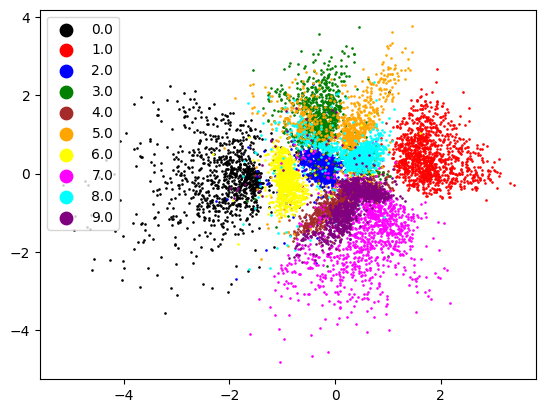

In [4]:
epochs2 = 50 # 10
S = False # Set True to save samples

# Define VAE model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc1a = nn.Linear(400, 100)
        self.fc21 = nn.Linear(100, 2) # Latent space of 2D
        self.fc22 = nn.Linear(100, 2) # Latent space of 2D
        self.fc3 = nn.Linear(2, 100) # Latent space of 2D
        self.fc3a = nn.Linear(100, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc1a(h1))
        return self.fc21(h2), self.fc22(h2)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        h4 = F.relu(self.fc3a(h3))
        return torch.sigmoid(self.fc4(h4))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD # -ELBO


def train(epoch):
    model.train() # so that everything has gradients and we can do backprop and so on...
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad() # "reset" gradients to 0 for text iteration
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward() # calc gradients
        train_loss += loss.item()
        optimizer.step() # backpropagation

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad(): # no_grad turns of gradients...
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


for epoch in range(1, epochs2 + 1):
    train(epoch)
    test(epoch)
    with torch.no_grad():
        if S==True:
            sample = torch.randn(64, 2).to(device) # 20 -> 2
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 28, 28),
                    'results/sample_' + str(epoch) + '.png')


mnist_test = list(test_loader)
B = len(mnist_test)
results = torch.zeros((128*B,2))
all_labels = torch.empty(0)
l = 0
for b in range(B):
    labels = mnist_test[b][1]
    all_labels = torch.cat((all_labels, labels))
    
    images = mnist_test[b][0]
    K = images.shape[0]
    for k in range(K):
        an_img = images[k,:,:,:]
        an_img_flat = torch.flatten(an_img)
        mean_img = model.encode(an_img_flat)[0]
        results[l] = mean_img
        l +=1
results = results[:l,:]
all_labels = all_labels[:l]

results_for_plot = results.detach().numpy()

scatter_x = results_for_plot[:,0]
scatter_y = results_for_plot[:,1]
group = all_labels

cdict = {0: 'black', 1: 'red', 2: 'blue', 3: 'green', 4: 'brown', 
         5: 'orange', 6: 'yellow', 7: 'magenta', 8: 'cyan', 9: 'purple'}

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 0.8)
ax.legend(markerscale = 10)
plt.show()
                

/Users/madsheller/Documents/MLA/MLA/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


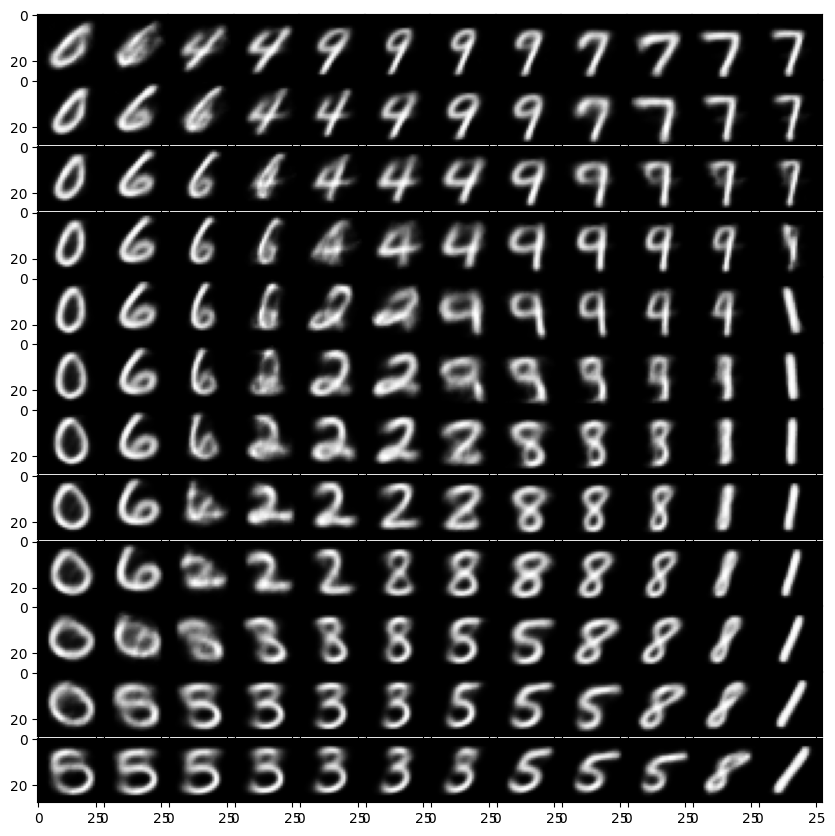

In [5]:
M = 12
x = torch.linspace(start=0, end=1, steps=M+2)
x = x[:-1]
x = x[1:]

mesh_x, mesh_y = torch.meshgrid(x, x)
gauss = torch.distributions.normal.Normal(loc = 0, scale = 1)
gauss_x = gauss.icdf(mesh_x)#.flip(0)
gauss_y = gauss.icdf(mesh_y)

fig, ax = plt.subplots(nrows=M, ncols=M, figsize=(8, 8), sharex = True, sharey = True)
for i in range(M):
    for j in range(M):
        x_val = gauss_x[i,j].item()
        y_val = gauss_y[i,j].item()
        im = model.decode(torch.Tensor([y_val, x_val]))
        im_plt = im.reshape((28,28))
        plot_me = im_plt.detach().numpy()
        ax[i,j].imshow(plot_me, cmap="gray")

slim=0.6
plt.tight_layout(pad=-slim, w_pad=-slim, h_pad=-slim)
plt.show()

In [ ]:
mnist_test = list(test_loader)
B = len(mnist_test)
all_labels = torch.empty(0)
pred = np.empty(0)
for b in range(B):
    labels = mnist_test[b][1]
    all_labels = torch.cat((all_labels, labels))
    
    images = mnist_test[b][0]
    K = images.shape[0]
    test_output, last_layer = cnn(VAE(images)[0].reshape((K,1,28,28)))
    pred_y = torch.max(test_output, 1)[1].data.squeeze()
    pred = np.append(pred, sum(labels==pred_y)/len(pred_y))
np.mean(pred)

# CNN-VAE

/Users/madsheller/Documents/MLA/MLA/lib/python3.10/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/Users/madsheller/Documents/MLA/MLA/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


====> Epoch: 1 Average loss: 213.7289
====> Test set loss: 175.7610
====> Epoch: 2 Average loss: 172.7163
====> Test set loss: 170.1581
====> Epoch: 3 Average loss: 167.8778
====> Test set loss: 166.2016
====> Epoch: 4 Average loss: 164.7725
====> Test set loss: 163.3956
====> Epoch: 5 Average loss: 162.5802
====> Test set loss: 161.4961
====> Epoch: 6 Average loss: 160.8651
====> Test set loss: 160.4946
====> Epoch: 7 Average loss: 159.6643
====> Test set loss: 159.5233
====> Epoch: 8 Average loss: 158.7485
====> Test set loss: 158.0685
====> Epoch: 9 Average loss: 157.9676
====> Test set loss: 157.6877
====> Epoch: 10 Average loss: 157.3584
====> Test set loss: 156.8927
====> Epoch: 11 Average loss: 156.7640
====> Test set loss: 156.6641
====> Epoch: 12 Average loss: 156.3032
====> Test set loss: 156.6052
====> Epoch: 13 Average loss: 155.8539
====> Test set loss: 155.9957
====> Epoch: 14 Average loss: 155.5255
====> Test set loss: 155.8940
====> Epoch: 15 Average loss: 155.2321
====

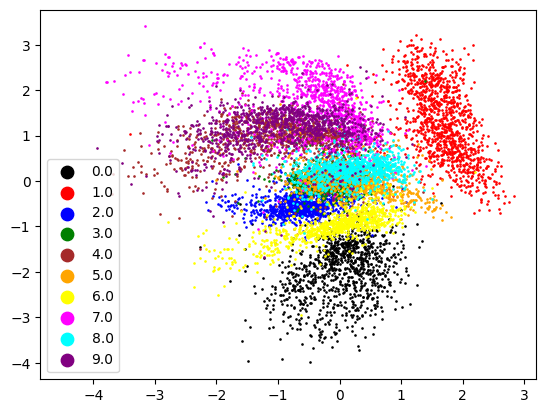

In [6]:
class CNNVAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),
            #nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5, padding=2), nn.ReLU(),
            #nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten()
        )

        self.fc1 = nn.LazyLinear(2)
        self.fc2 = nn.LazyLinear(2)
        self.fc3 = nn.Linear(2, 16*28*28)

        self.decoder = nn.Sequential(
            nn.Unflatten(-1,(16,28,28)),
            nn.LazyConvTranspose2d(6, kernel_size=5, padding=2), nn.ReLU(),
            nn.LazyConvTranspose2d(1, kernel_size=5, padding=2), nn.Sigmoid()
                )
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def encode(self, x):
        x = self.encoder(x)
        return self.fc1(x), self.fc2(x)

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

model = CNNVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD # -ELBO


def train(epoch):
    model.train() # so that everything has gradients and we can do backprop and so on...
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad() # "reset" gradients to 0 for text iteration
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward() # calc gradients
        train_loss += loss.item()
        optimizer.step() # backpropagation

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad(): # no_grad turns of gradients...
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


for epoch in range(1, epochs2 + 1):
    train(epoch)
    test(epoch)
    with torch.no_grad():
        if S==True:
            sample = torch.randn(64, 2).to(device) # 20 -> 2
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 28, 28),
                    'results/CNNVAE_sample_' + str(epoch) + '.png')

mnist_test = list(test_loader)
images = mnist_test[0][0]
results_for_plot = model.encode(images[:,:,:,:])

mnist_test = list(test_loader)
B = len(mnist_test)
results = torch.zeros((128*B,2))
all_labels = torch.empty(0)
l = 0
for b in range(B):
    labels = mnist_test[b][1]
    all_labels = torch.cat((all_labels, labels))
    
    images = mnist_test[b][0]
    K = images.shape[0]
    results[K*b:K*(b+1)] = model.encode(images[:,:,:,:])[0]

results_for_plot = results.detach().numpy()

mnist_test = list(test_loader)
B = len(mnist_test)
results = torch.zeros((128*B,2))
all_labels = torch.empty(0)
l = 0
for b in range(B):
    labels = mnist_test[b][1]
    all_labels = torch.cat((all_labels, labels))
    
    images = mnist_test[b][0]
    K = images.shape[0]
    results[K*b:K*(b+1)] = model.encode(images[:,:,:,:])[0]

results_for_plot = results.detach().numpy()

scatter_x = results_for_plot[:,0]
scatter_y = results_for_plot[:,1]
group = all_labels

cdict = {0: 'black', 1: 'red', 2: 'blue', 3: 'green', 4: 'brown', 
        5: 'orange', 6: 'yellow', 7: 'magenta', 8: 'cyan', 9: 'purple'}

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 0.8)
ax.legend(markerscale = 10)
plt.show()

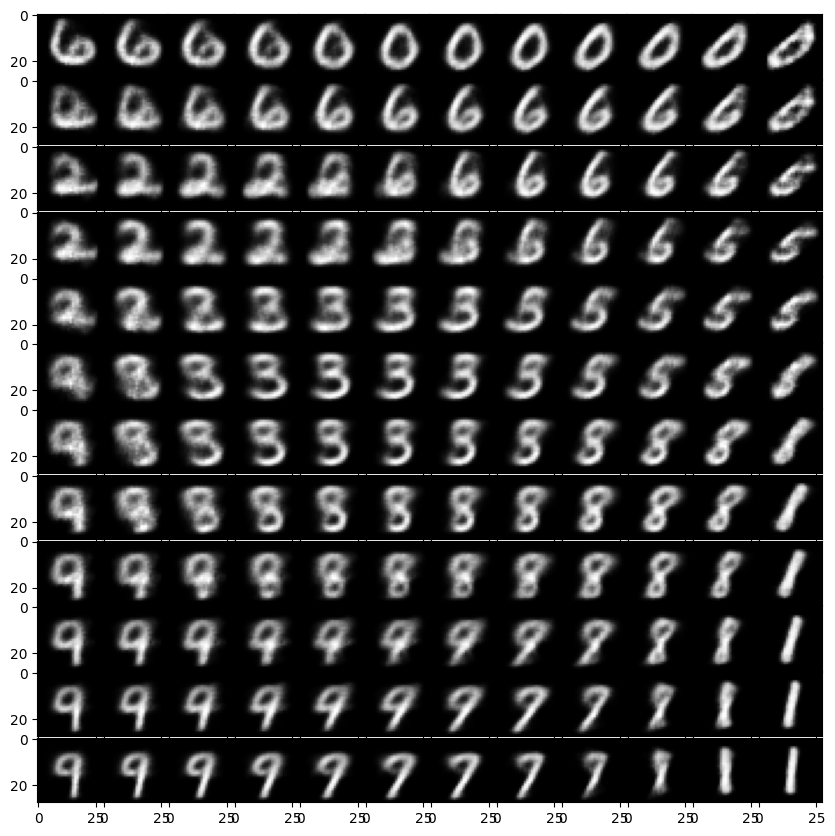

In [7]:
M = 12
x = torch.linspace(start=0, end=1, steps=M+2)
x = x[:-1]
x = x[1:]

mesh_x, mesh_y = torch.meshgrid(x, x)
gauss = torch.distributions.normal.Normal(loc = 0, scale = 1)
gauss_x = gauss.icdf(mesh_x)#.flip(0)
gauss_y = gauss.icdf(mesh_y)

fig, ax = plt.subplots(nrows=M, ncols=M, figsize=(8, 8), sharex = True, sharey = True)
for i in range(M):
    for j in range(M):
        x_val = gauss_x[i,j].item()
        y_val = gauss_y[i,j].item()
        im = model.decode(torch.Tensor([y_val, x_val]))
        im_plt = im.reshape((28,28))
        plot_me = im_plt.detach().numpy()
        ax[i,j].imshow(plot_me, cmap="gray")

slim=0.6
plt.tight_layout(pad=-slim, w_pad=-slim, h_pad=-slim)
plt.show()

In [ ]:
model.eval()
mnist_test = list(test_loader)
B = len(mnist_test)
all_labels = torch.empty(0)
pred = np.empty(0)
for b in range(B):
    labels = mnist_test[b][1]
    all_labels = torch.cat((all_labels, labels))
    
    images = mnist_test[b][0]
    test_output, last_layer = cnn(model(images)[0])
    pred_y = torch.max(test_output, 1)[1].data.squeeze()
    pred = np.append(pred, sum(labels==pred_y)/len(pred_y))
np.mean(pred)

# Diffusion model

In [3]:
from torchvision.datasets import MNIST

batch_size2 = 128

tf = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1) # Scales to [-1,1]
         ]
    )

train = MNIST(
    "./data",
    train=True,
    download=True,
    transform=tf,
)
dataloader_train = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)

test = MNIST(
    "./data",
    train=False,
    download=True,
    transform=tf,
)
dataloader_test = torch.utils.data.DataLoader(test, batch_size=128, shuffle=True)

In [37]:
epochs2=10
S=False
T = 200
beta1 = 1e-4
beta2 = 0.01

def schedule():
    beta_t = torch.linspace(beta1, beta2, T)
    sqrt_beta_t = torch.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

    sqrtab = torch.sqrt(alphabar_t)
    oneover_sqrta = 1 / torch.sqrt(alpha_t)

    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab

    return {
        "alpha_t": alpha_t, 
        "oneover_sqrta": oneover_sqrta, 
        "sqrt_beta_t": sqrt_beta_t,  
        "alphabar_t": alphabar_t,  
        "sqrtab": sqrtab, 
        "sqrtmab": sqrtmab,  
        "mab_over_sqrtmab": mab_over_sqrtmab_inv,
    }

def forward_diffusion(x0, t, schedule=schedule()):
    epsilon = torch.randn_like(x0)
    xt = schedule["sqrtab"][t, None, None, None] * x0 + schedule["sqrtmab"][t, None, None, None] * epsilon

    return xt, epsilon

class Unet(nn.Module):

    def __init__(self) -> None:
        super(Unet, self).__init__()
        self.conv = nn.Sequential(  # with batchnorm
            nn.Conv2d(1, 32, 7, padding=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #nn.Conv2d(64, 128, 7, padding=3),
            #nn.BatchNorm2d(128),
            #nn.ReLU(),
            #nn.Conv2d(128, 64, 7, padding=3),
            #nn.BatchNorm2d(64),
            #nn.ReLU(),
            nn.Conv2d(64, 32, 7, padding=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 1, 3, padding=1),
        )

    def forward(self, x, t) -> torch.Tensor:
        return self.conv(x)

#model = DDPM(eps_model=Unet())
model = Unet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def loss_function(model, x0, t):
    xt, noise = forward_diffusion(x0, t)
    pred = model(xt, t)
    return F.mse_loss(noise, pred)


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(dataloader_train):
        data = data.to(device)
        optimizer.zero_grad()
        batch_s = data.shape[0]
        t = torch.randint(0, T, (batch_s,), device=device)
        loss = loss_function(model, data, t)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print('====> Epoch: {} Average loss: {:.4f}'.format(
         epoch, train_loss / len(dataloader_train)))



def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad(): # no_grad turns of gradients...
        for i, (data, _) in enumerate(dataloader_test):
            data = data.to(device)
            loss = model(data)
            test_loss += loss.item()
    



for epoch in range(1, epochs2 + 1):
    train(epoch)
    #test(epoch)
    with torch.no_grad():
        if S==True:
            1

====> Epoch: 1 Average loss: 0.1578
====> Epoch: 2 Average loss: 0.1104
====> Epoch: 3 Average loss: 0.1005
====> Epoch: 4 Average loss: 0.0944
====> Epoch: 5 Average loss: 0.0915
====> Epoch: 6 Average loss: 0.0882
====> Epoch: 7 Average loss: 0.0862
====> Epoch: 8 Average loss: 0.0834
====> Epoch: 9 Average loss: 0.0822
====> Epoch: 10 Average loss: 0.0821


In [24]:
# Algorithm 2
#@torch.no_grad 
def sample(n_sample ,size = (1,28,28), schedule=schedule(), model=model):
    
    x_i = torch.randn(n_sample, *size, device=device) # x_T

    for i in range(0,T)[::-1]:
        z = torch.randn(n_sample, *size).to(device) if i > 1 else 0
        epsilon = model(x_i,i)
        x_i = (
            schedule["oneover_sqrta"][i] * (x_i - epsilon * schedule["mab_over_sqrtmab"][i])
            + schedule["sqrt_beta_t"][i] * z
        )
    return x_i


In [93]:
def denoise(xt, t, size = (1,28,28), schedule=schedule(),model=model):
    for i in range(0,t[0])[::-1]:
        z = torch.randn(1, *size).to(device) if i > 1 else 0
        epsilon = model(xt,i)
        xt = (
            schedule["oneover_sqrta"][i] * (xt - epsilon * schedule["mab_over_sqrtmab"][i])
            + schedule["sqrt_beta_t"][i] * z
        )
    return xt


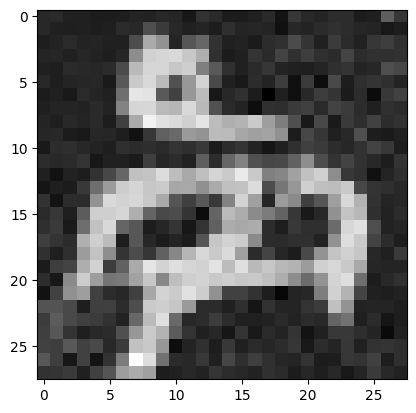

In [74]:
temp = sample(1)
plt.imshow(temp[0][0].detach(), cmap="gray")

In [73]:
from torchvision.utils import make_grid

samples = sample(16)
grid = make_grid(samples, nrow=4)

save_image(grid, f"./results/ddpm_sample_{1}.png")

In [104]:
model.eval()
mnist_test = list(dataloader_test)
B = len(mnist_test)
all_labels = torch.empty(0)
pred = np.empty(0)
for b in range(B):
    labels = mnist_test[b][1]
    all_labels = torch.cat((all_labels, labels))
    
    images = mnist_test[b][0]
    ## Add noise to the test images
    K = images.shape[0]
    t = torch.full((K,), torch.tensor(50), device=device)
    img, noise = forward_diffusion(images, t)

    ## Use the model to recover the test images
    rec = denoise(img, t) 

    ## Predict   
    test_output, last_layer = cnn(rec)
    pred_y = torch.max(test_output, 1)[1].data.squeeze()
    pred = np.append(pred, sum(labels==pred_y)/len(pred_y))
np.mean(pred)

0.09098101265822785